In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import PIL.Image as Image
import os

import tensorflow as tf
import tensorflow_hub as hub
import keras
from tensorflow.keras import layers
from keras.models import Model
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.utils import load_img, img_to_array

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input

In [2]:
training_path = '/content/drive/MyDrive/Project Vilians Image Classification/training'
testing_path = '/content/drive/MyDrive/Project Vilians Image Classification/testing'
test_path = '/content/drive/MyDrive/Project Vilians Image Classification/testing/test'

In [3]:
vgg = VGG16(input_shape = (224, 224, 3), weights = 'imagenet', include_top = False)

58889256/58889256 [==============================] - 1s 0us/step


In [4]:
for layer in vgg.layers:
  layer.trainable = False

In [5]:
train_datagen = ImageDataGenerator(rescale = 1.0/255,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   zoom_range = 0.2,
                                   shear_range = 0.2,
                                   horizontal_flip = True,
                                   validation_split = 0.2)

train_generator = train_datagen.flow_from_directory(training_path,
                                                    target_size = (224, 224),
                                                    batch_size = 8,
                                                    class_mode = 'categorical',
                                                    shuffle = True,
                                                    seed = 10,
                                                    subset = 'training')

val_generator =  train_datagen.flow_from_directory(training_path,
                                                   target_size = (224, 224),
                                                    batch_size = 8,
                                                   class_mode = 'categorical',
                                                    shuffle = True,
                                                    seed = 10,
                                                    subset = 'validation')

Found 65 images belonging to 5 classes.
Found 15 images belonging to 5 classes.


In [6]:
test_datagen = ImageDataGenerator(1.0/255)

test_generator = test_datagen.flow_from_directory(testing_path,
                                                  target_size = (224, 224),
                                                  classes = ['test'],
                                                  batch_size = 8)

Found 15 images belonging to 1 classes.


In [7]:
labels = train_generator.class_indices
labels = dict((v, k) for k, v in labels.items())
labels

{0: 'Darth Vader', 1: 'Green Goblin', 2: 'Joker', 3: 'Thanos', 4: 'Venom'}

In [8]:
x = vgg.output
x = Flatten()(x)
output_layer = Dense(units = 5, activation = 'softmax')(x)
model = Model(inputs = vgg.input, outputs = output_layer)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [9]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])


In [11]:
hist = model.fit(train_generator, epochs = 10, validation_data = val_generator)

Epoch 1/10
9/9 [==============================] - 2s 221ms/step - loss: 0.2683 - accuracy: 0.8923 - val_loss: 1.3115 - val_accuracy: 0.6000
Epoch 2/10
9/9 [==============================] - 1s 164ms/step - loss: 0.7942 - accuracy: 0.7231 - val_loss: 1.0075 - val_accuracy: 0.6000
Epoch 3/10
9/9 [==============================] - 2s 213ms/step - loss: 0.3794 - accuracy: 0.8923 - val_loss: 1.4377 - val_accuracy: 0.6667
Epoch 4/10
9/9 [==============================] - 2s 259ms/step - loss: 0.4647 - accuracy: 0.8154 - val_loss: 1.1226 - val_accuracy: 0.7333
Epoch 5/10
9/9 [==============================] - 1s 157ms/step - loss: 0.2718 - accuracy: 0.8769 - val_loss: 0.9930 - val_accuracy: 0.6667
Epoch 6/10
9/9 [==============================] - 1s 166ms/step - loss: 0.2649 - accuracy: 0.8615 - val_loss: 1.3863 - val_accuracy: 0.6000
Epoch 7/10
9/9 [==============================] - 1s 147ms/step - loss: 0.2259 - accuracy: 0.9538 - val_loss: 0.8617 - val_accuracy: 0.6667
Epoch 8/10
9/9 [====

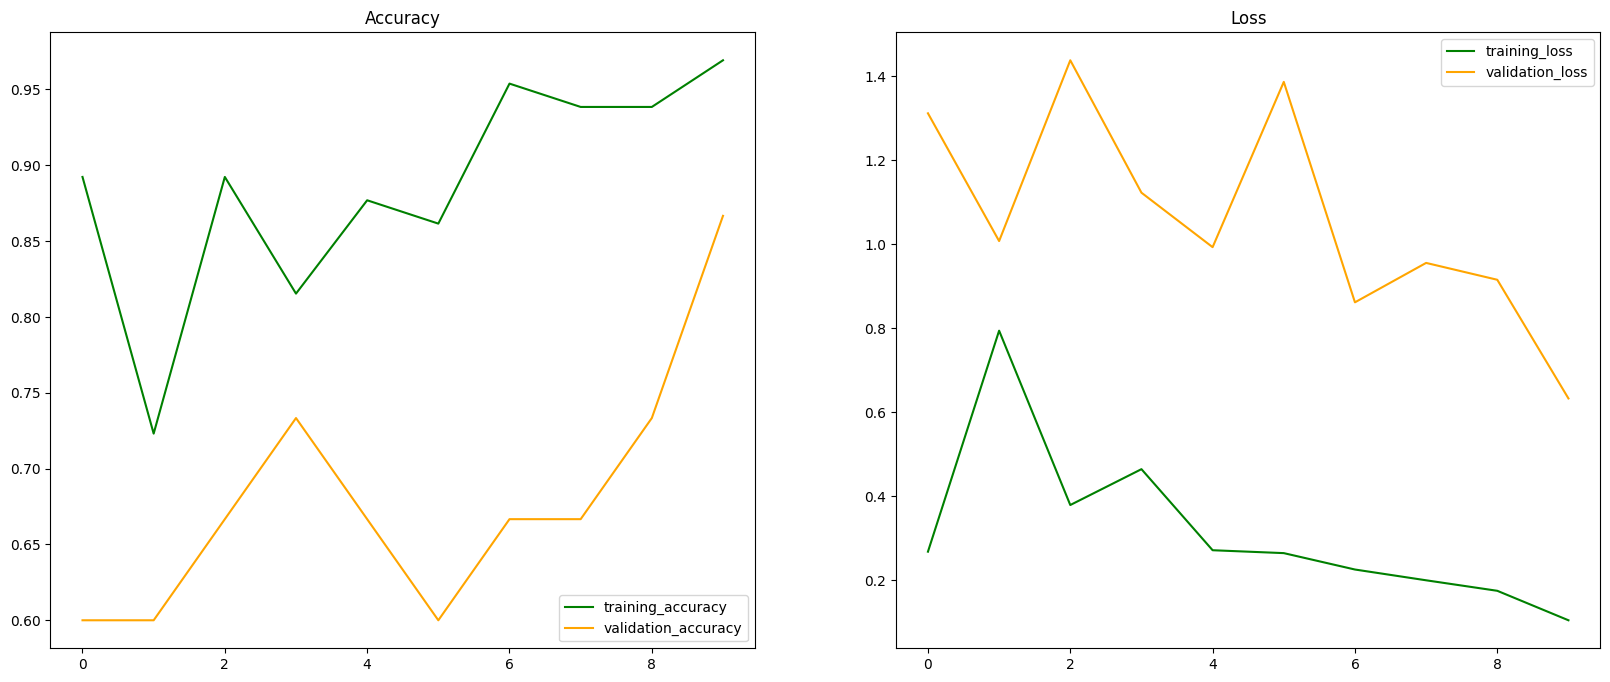

In [12]:
plt.figure(figsize = (20, 8))

plt.subplot(1, 2, 1)
train_acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(10)
plt.plot(epochs, train_acc, label = 'training_accuracy', color = 'green')
plt.plot(epochs, val_acc, label = 'validation_accuracy', color = 'orange')
plt.legend(loc = 'lower right')
plt.title('Accuracy')


plt.subplot(1, 2, 2)
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(10)
plt.plot(epochs, train_loss, label = 'training_loss', color = 'green')
plt.plot(epochs, val_loss, label = 'validation_loss', color = 'orange')
plt.legend(loc = 'upper right')
plt.title('Loss')

plt.show()

In [13]:
def predict_image(path):

  img = load_img(path, target_size = (224, 224))
  img_array = img_to_array(img)
  img_array = img_array/255
  img_array = np.expand_dims(img_array, axis = 0)

  classes = model.predict([img_array])
  class_index = np.argmax(classes, axis = 1)[0]
  class_name = labels[class_index]

  im = mpimg.imread(path)
  plt.imshow(im)
  print(f"Predicted class is {class_name}")



1/1 [==============================] - 0s 157ms/step
Predicted class is Green Goblin


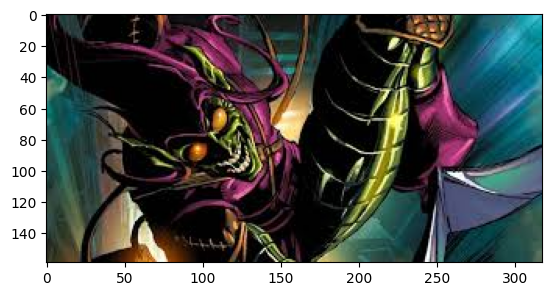

In [14]:
predict_image('/content/drive/MyDrive/Project Vilians Image Classification/testing/test/Green Goblin 7.jpg')

1/1 [==============================] - 0s 35ms/step
Predicted class is Joker


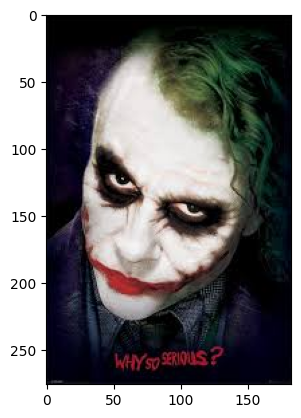

In [15]:
predict_image('/content/drive/MyDrive/Project Vilians Image Classification/testing/test/Joker 7.jpg')

1/1 [==============================] - 0s 20ms/step
Predicted class is Thanos


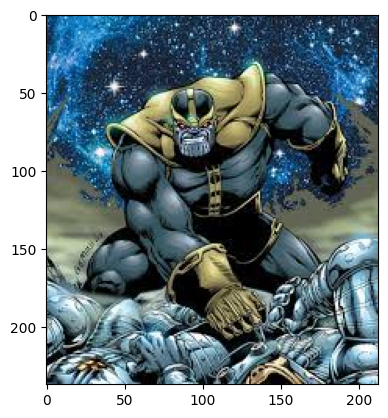

In [16]:
predict_image('/content/drive/MyDrive/Project Vilians Image Classification/testing/test/Thanos 9.jpg')

1/1 [==============================] - 0s 27ms/step
Predicted class is Darth Vader


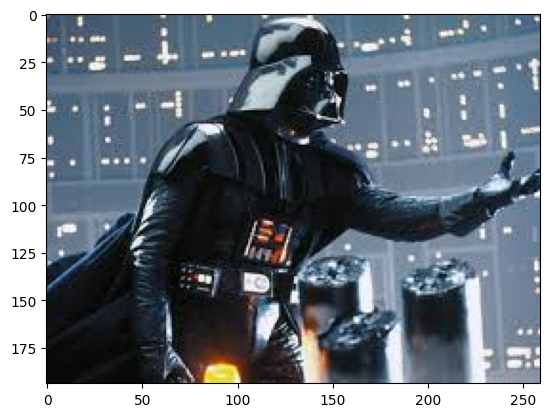

In [17]:
predict_image('/content/drive/MyDrive/Project Vilians Image Classification/testing/test/Vader 7.jpg')

1/1 [==============================] - 0s 20ms/step
Predicted class is Thanos


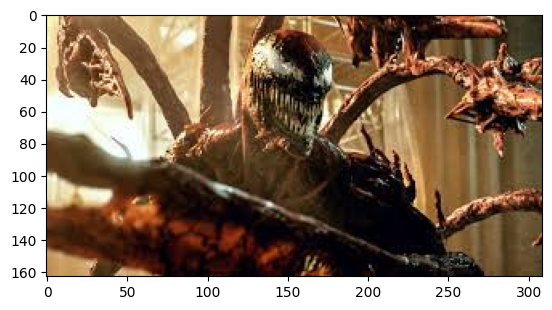

In [18]:
predict_image('/content/drive/MyDrive/Project Vilians Image Classification/testing/test/Venom 8.jpg')

In [19]:
model.save('villian_image_classification_VGG16.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
